In [1]:
##references
    #.describe(); https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
    #

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import desc

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found (tables in the sqlite file)(separate csvs are in resources)
table_names = Base.classes.keys()
table_names

['measurement', 'station']

In [7]:
# Save references to each table
measurement= Base.classes.measurement
station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

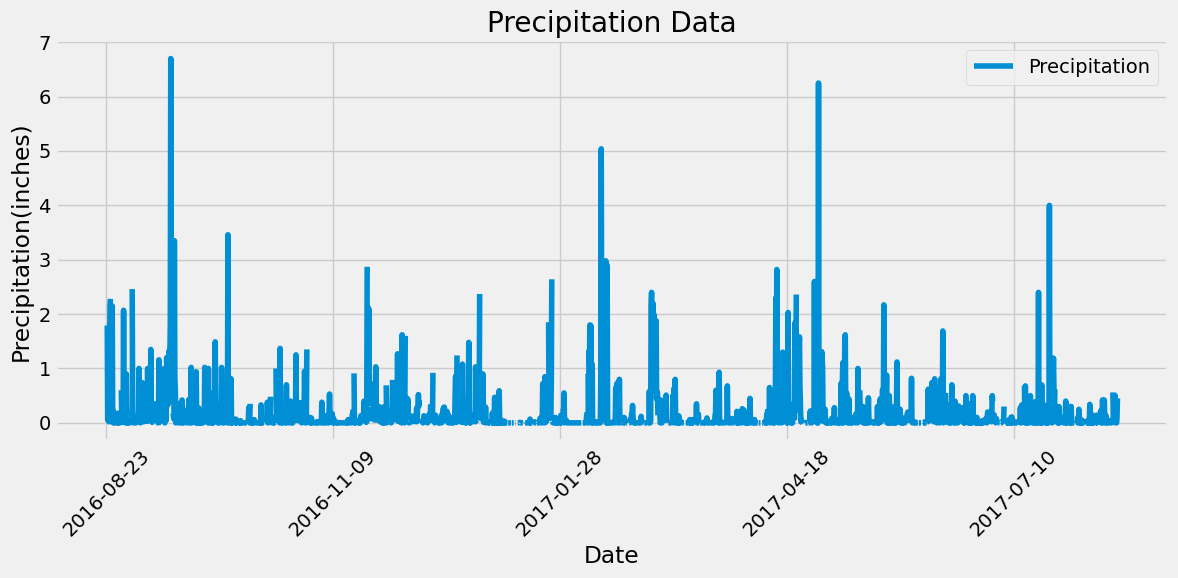

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date=session.query(func.max(measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
          filter(measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Precipitation(inches)')
plt.title('Precipitation Data')
plt.xticks(rotation= 45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats= sorted_df['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print("Total number of stations: ", total_stations)

Total number of stations:  9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import desc

# Query to find the most active stations
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                group_by(measurement.station).\
                order_by(desc(func.count(measurement.station))).all()

# Print the results
for station, row_count in active_stations:
    print("Station:", station, "- Rows:", row_count)


Station: USC00519281 - Rows: 2772
Station: USC00519397 - Rows: 2724
Station: USC00513117 - Rows: 2709
Station: USC00519523 - Rows: 2669
Station: USC00516128 - Rows: 2612
Station: USC00514830 - Rows: 2202
Station: USC00511918 - Rows: 1979
Station: USC00517948 - Rows: 1372
Station: USC00518838 - Rows: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station= session.query(measurement.station).\
                      group_by(measurement.station).\
                      order_by(func.count(measurement.station).desc()).\
                      first()

results = session.query(func.max(measurement.tobs),
                        func.min(measurement.tobs),
                        func.avg(measurement.tobs)).\
          filter(measurement.station == most_active_station[0]).\
          first()

highest_temp = results[0]
lowest_temp = results[1]
avg_temp = results[2]

print("Highest Temperature:", highest_temp)
print("Lowest Temperature:", lowest_temp)
print("Average Temperature:", avg_temp)

Highest Temperature: 85.0
Lowest Temperature: 54.0
Average Temperature: 71.66378066378067


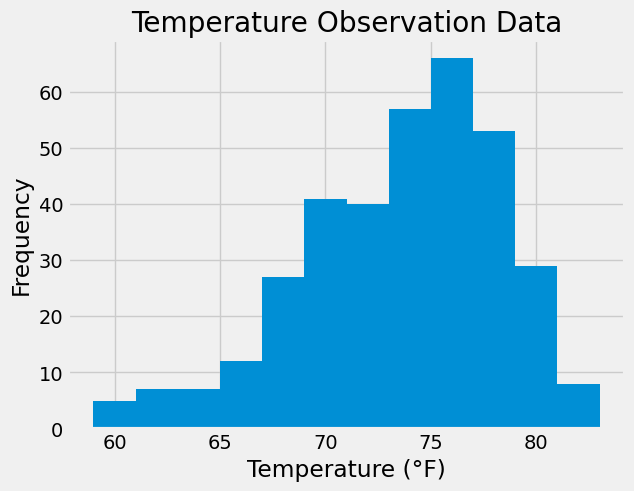

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.tobs).\
          filter(measurement.station == most_active_station[0]).\
          filter(measurement.date >= one_year_ago_str).all()

temperatures = [result[0] for result in results]

plt.hist(temperatures, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()